# Pruebas del método de volumen finito
- Óscar Alvarado
- Oscar Esquivel

Aquí se hace el intento de cambiar de orientación las diagonales de la matriz A para que tenga algo más de sentido, el problema aquí es cuando se pasa a dos dimensiones, se pierde todo el orden.

In [50]:
import numpy as np
import plotly.graph_objects as go
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

## Índice

1. [Mallado](#Mallado)
2. [Mallado escalonado](#Staggered-grids)
3. [SIMPLE](#SIMPLE)
4. [Coeficientes](#Coeficientes)
5. [Difusión](#Difusión)
6. [Advección](#Advección)
7. [Sistema de ecuaciones](#Sistema-de-ecuaciones)
8. [Problemas](#Problemas)
    - [Una dimensión](#Una-dimensión)
    - [Una dimensión con advección](#Una-dimensión-con-advección)
    - [Dos dimensiones](#Dos-dimensiones)
    - [Ecuación de Poisson](#Ecuación-de-Poisson)
    - [Tres dimensiones](#Tres-dimensiones)
    - [Lid-driven Cavity](#Lid-driven-Cavity)

## Mallado

In [51]:
class Mesh():
    """
    Clase del mallado
    """
    def __init__(self, dim, volumes = None, lengths = None):
        """
        Constructor de la clase Malla.
        """

        self.volumes = (1,1,1)
        self.lengths = (0.01, 0.01, 0.01)

        #----default values for positions and separations of the grid-------------
        self.coords = [(0.005,) for _ in range(3)] # Coordenadas de los centros de los volúmenes
        self.dominios = [tuple([0.]+[self.coords[i][0]]+[self.lengths[i]]) for i in range(3)]
        self.deltas = [(0,) for _ in range(3)]
        # Hasta aquí tenemos un cubito

        self.__tags = {} # El etiquetado de todos los nodos sin fronteras
        self.__tags_fronteras = {} # El etiquetado de las fronteras
        
        self.dim = dim
        if isinstance(volumes, int):  self.volumes = (volumes, 1, 1)
        if isinstance(lengths, (int, float)):  self.lengths = (lengths, lengths/10, lengths/10)
        
        # Si los parámetros son tuplas (pero no necesariamente sería una tupla de 3), arreglamos eso:
        if isinstance(volumes, tuple):
            faltan = 3 - len(volumes)
            self.volumes = volumes + tuple([1 for i in range(faltan)])
        if isinstance(lengths, tuple): 
            faltan = 3 - len(lengths)
            self.lengths = lengths + tuple([lengths[0]/10 for i in range(faltan)])
        #---------------------------------------------------------------
        
        # if volumes and lengths are given, initialize values acording to dimension
        if (volumes and lengths):       
            self.uniform_grid()
            self.init_tags()
            self.init_tags_fronteras()
    
    
    def uniform_grid(self):
        l = np.array(self.lengths) # Para el manejo con numpy
        v = np.array(self.volumes)
        d = l/v # Separación entre todos los nodos de cada dimensión
        start = d/2 # La frontera "inicial" del arreglo
        stop = l-d/2 # La frontera "final" del arreglo
        self.coords = [tuple(np.linspace(strt, stp, vol)) \
                       for strt, stp, vol in list(zip(start, stop, v))] # Meshgrid posible
        dominios = [np.insert(arr,(0,len(arr)),[0, l[idx]]) \
                    for idx, arr in enumerate(self.coords)] # Coordenadas + fronteras
        # Separación entre los nodos (Aquí hay que ver cómo es cuando tenemos un grid 
        # de 2x1x1 ya cuando se haga el FVM
        self.deltas = [self.set_deltas(dom)  if len(self.set_deltas(dom)) != 0 \
                       else (dom[-1],) for dom in dominios]
        self.dominios = [tuple(dom) for dom in dominios]
        #self.faces = [tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) for coords in self.coords]
        self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.get_grids()
    
    
    def set_deltas(self, dominio):
        """
        Método para obtener la distancia que hay entre los nodos
        """
        return tuple((dominio[1:]-dominio[:-1])[1:-1])


    # Creo que esto no se usará, pero estuvo chida la deducción, lo dejo de todos modos xd
    #def totalDomNodes(self):
    #    d_1 = 6*self.volumes[0] + 1
    #    d_2 = self.volumes[1]*d_1 - self.volumes[0]*(self.volumes[1] - 1)
    #    d_3 = self.volumes[2]*d_2 - self.volumes[0]*self.volumes[1]*(self.volumes[2] - 1)
    #    return d_3
    
    def init_tags(self):
        """
        Método que etiqueta las caras adyacentes de cada volumen dependiendo de la geometría. Pone un {} 
        (diccionario vacío) cuando es una frontera, una 'F' cuando es una cara interna y un 'Off' cuando 
        no se está contando esa cara por las dimensiones del problema. 
        """
        self.__tags = {}
        X, Y, Z = self.volumes
        for z in range(1,Z+1):
            for y in range(1,Y+1):
                for x in range(1,X+1):                   
                    t = b = n = s = "Off"
                    e = w = "F"
                    if x == 1: w = {}
                    elif x == X: e = {}
                    if self.dim > 1:
                        n = s = "F"
                        if y == 1: n = {}
                        elif y == Y: s = {}
                        if self.dim == 3:
                            t = b = "F"
                            if z == 1: t = {}
                            elif z == Z: b = {}
                    self.__tags[f"{x}-{y}-{z}"] = {"E": e, "W": w, "N": n, "S": s, "T": t, "B": b, 
                                             "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                       self.dominios[2][z]]}
    
    def init_tags_fronteras(self):
        """
        Método para etiquetar las fronteras dependiendo de la dimensión, sólo se les da la propiedad de 
        existir o no existir.
        """
        self.__tags_fronteras = {}
        X, Y, Z = [len(dom) for dom in self.dominios]
        for z in range(Z):
            for y in range(Y):
                for x in range(X):
                    t = b = n = s = "Off"
                    e = w = "ON"
                    if self.dim > 1: 
                        n = s = "ON"
                        if self.dim == 3: t = b = "ON"
                    # El siguiente cacho de código es para saber si nos encontramos con una frontera
                    if x==0 or y==0 or z==0 or x==(X-1) or y==(Y-1) or z==(Z-1):
                        var = None
                        if y != 0 and y != (Y - 1):
                            if z != 0 and z != (Z - 1):
                                if x == 0: var = "W"; value = w
                                elif x == (X - 1): var = "E"; value = e
                                else: continue
                            elif x != 0 and x != (X - 1):
                                if z == 0: var = "T"; value = t
                                elif z == (Z - 1): var = "B"; value = b
                                else: continue
                            else: continue
                            self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y],
                                                           self.dominios[2][z]], "cond": {}} 
                        elif z != 0 and z != (Z - 1):
                            if x != 0 and x != (X - 1):
                                if y == 0: var = "N"; value = n
                                elif y == (Y - 1) : var = "S"; value = s
                                self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                           self.dominios[2][z]], "cond": {}} 
                        else: continue
            
    def tag_wall(self, direction, tag, value):
        """
        Método para etiquetar fronteras dada la dirección, el tipo de condición de frontera y el valor.
        """
        for key in self.__tags.keys():
            if isinstance(self.__tags[key][direction], dict):
                self.__tags[key][direction][tag] = value
        for key in self.__tags_fronteras.keys():
            if self.__tags_fronteras[key]["frontera"].get(direction) == "ON":
                self.__tags_fronteras[key]["cond"][tag] = value

    def tag_wall_dirichlet(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Dirichlet dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["D"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["D"] =  value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "D", value[idx])
            else:
                self.tag_wall(direction, "D", value)
                    
    def tag_wall_neumann(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["N"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["N"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "N", value[idx])
            else:
                self.tag_wall(direction, "N", value)
                    
    def tag_wall_source(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["S"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["S"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "S", value[idx])
            else:
                self.tag_wall(direction, "S", value)
                
                
    def tag_wall_insulated(self, direction, coords=None):
        """
        Método para etiquetar fronteras con condición de aislamiento.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["I"] = None
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["I"] = None
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "I", None)
            else:
                self.tag_wall(direction, "I", None)
                
    
    def set_dominio(self, dominio, faces=None):
        """
        Método para definir el dominio de estudio dadas unas coordenadas en forma de tupla.
        """
        # Si 'dominio' no es tupla, transforma 'dominio' a la tupla unidimensional (dominio,)
        # Tendría que ser una tupla de tuplas/listas/arreglos para que sea válido.
        if not isinstance(dominio, (tuple, int, float)): # Creo que si es una lista o un arreglo, no int o float
            tupla = (tuple(dominio), self.dominios[1], self.dominios[2])
            dominio = tupla
        # Asigna los atributos de la mesh correspondientes    
        self.dominios = [tuple(dominio[i]) for i in range(3)]
        self.coords = [tuple(dominio[i][1:-1]) for i in range(3)]
        self.lengths = tuple([dominio[i][-1] for i in range(3)])
        self.volumes = tuple([len(dominio[i][1:-1]) for i in range(3)])
        #self.deltas = [self.set_deltas(np.array(dominio[i])) for i in range(3)]
        self.deltas = [self.set_deltas(np.array(dom))  if len(self.set_deltas(np.array(dom))) != 0 \
                       else (dom[-1],) for dom in self.dominios]
        
        if faces: 
            # Si me está pasando una lista (o sea, es de una dimensión)
            if isinstance(faces[0], (int, float)):
                self.faces = tuple(dominio[0]) + tuple(faces) + tuple(dominio[-1])
            else: # Suponemos aquí que nos está pasando una lista de listas (o tupla de tuplas)
                for idx, face_1dim in enumerate(faces):
                    faces[idx] = (dominio[idx][0], ) + tuple(face_1dim) + (dominio[idx][-1], )
                self.faces = faces
        else: 
            self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.init_tags()
        self.init_tags_fronteras()
        self.get_grids()
    
    def get_grid_deltas_dominios(self, axis=0, orientation="E", reverse=False):
        deltas_dominios = []
        self.grid_deltas_dominios = np.array([])
        dominios = [np.array(dom) for dom in self.dominios]
        coords = [np.array(coord) for coord in self.coords]
        for direction in range(3):
            if direction != axis:
                if len(dominios[direction]) == 3:
                    deltas_dominios.append(dominios[direction][1])
                else:
                    deltas_dominios.append(coords[direction])
            else:
                deltas_dominios.append(dominios[direction][1:] - dominios[direction][:-1])
        if orientation == "E" or orientation == "S" or orientation == "B":
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
        else:
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
        self.grid_deltas_dominios = np.meshgrid(deltas_dominios[0], deltas_dominios[1], deltas_dominios[2], 
                                                indexing='ij')
        return self.grid_deltas_dominios
    
    def get_grid_deltas_faces(self, axis=0, orientation="E", reverse=False):
        deltas_faces = []
        self.grid_deltas_faces = np.array([])
        faces = [np.array(face) for face in self.faces]
        dominios = [np.array(dominio) for dominio in self.dominios]
        coords = [np.array(coord) for coord in self.coords]
        for direction in range(3):
            if direction != axis:
                if len(dominios[direction]) == 3:
                    deltas_faces.append(dominios[direction][1])
                else:
                    deltas_faces.append(coords[direction])
            else:
                deltas_faces.append(faces[direction][1:] - faces[direction][:-1])
        
        self.grid_deltas_faces = np.meshgrid(deltas_faces[0], deltas_faces[1], deltas_faces[2], 
                                                indexing='ij')
        return self.grid_deltas_faces
    
    
    def get_deltas_faces(self):
        self.deltas_faces = []
        faces = [np.array(caras) for caras in self.faces]
        dominio = [np.array(doms) for doms in self.dominios]
        for direction in range(3):
            self.deltas_faces.append(faces[direction][1:] - faces[direction][:-1])
            
    def get_grids(self):
        self.grid_deltas = np.array([])
        self.grid_faces = np.array([])
        self.grid_coords = np.array([])
        deltas = self.deltas
        coords = self.coords
        faces = self.faces
        self.grid_deltas = np.meshgrid(deltas[0], deltas[1], deltas[2], indexing='ij')
        self.grid_coords = np.meshgrid(coords[0], coords[1], coords[2], indexing='ij')
        self.grid_faces = np.meshgrid(faces[0], faces[1], faces[2], indexing='ij')
                
    
    def info(self):
        """
        Método para imprimir información relevante del mallado
        """
        print('=====================================')
        print('     MESH INFORMATION   ')
        print('=====================================')
        print("\nMesh type: Cartesian")
        print(f"Number of dimensions of mesh: {self.dim}")
        variables = "X Y Z".split()
        for idx in range(self.dim):
            var = variables[idx]
            print(f"\n ----- {var}-axis -----")
            print(f"Number of {var.lower()} volumes: {self.volumes[idx]}")
            print(f"Lenght {var.lower()} of problem domain: {self.lengths[idx]}")
            print(f"List of {var.lower()} positions of volumes: \n{self.coords[idx]}")
            print(f"List of {var.lower()} positions of domain nodes: \n{self.dominios[idx]}")
            
            
    def draw(self):
        """
        Método para graficar la malla. Este método se invoca hasta que se hayan inizializado todas las condiciones
        de frontera.
        """
        # Graficamos las fronteras, sean o no activas
        dic_colors = {"D": "darkturquoise", "N": "red", "S": "magenta", "Off": "white", "I": "gray"}
        condiciones = [list(self.__tags_fronteras[key]["cond"].keys())[0] \
                       if list(self.__tags_fronteras[key]["frontera"].values())[0] == "ON" \
                       else "Off" for key in list(self.__tags_fronteras.keys())]
        colores = [dic_colors[cond] for cond in condiciones]
        # Obtenemos las coordenadas de las fronteras y de los nodos internos.
        coordenadas = [] # Aquí se pondrán las coordenadas de las fronteras
        coord = [] # Aquí las coordendas de los nodos internos
        for i in range(3):
            coordenadas.append([self.__tags_fronteras[key]["coord"][i] \
                                for key in list(self.__tags_fronteras.keys())])
            coord.append([self.__tags[key]["coord"][i] for key in list(self.__tags.keys())])
        fig = go.Figure(data = go.Scatter3d(x = coordenadas[0], y = coordenadas[1], z = coordenadas[2],
                                          mode = 'markers', marker = dict(color = colores, 
                                                                          symbol = "square", size = 2)))
        fig.add_trace(go.Scatter3d(x = coord[0], y = coord[1], z = coord[2],
                                              mode = 'markers', marker = dict(color = "blue", size = 5)))
        fig.show()


    def get_area(self, direction = 0, extended=False):
        """
        Método que regresa las áreas del volumen en la dirección indicada
        """
        perpendicular = [i for i in range(3) if i != direction]
        num_fronteras = self.volumes[direction]
        #if inplace:
        #    arreglo = [self.deltas_faces[idx][1:-1] if idx in perpendicular else np.ones(num_fronteras) \
        #          for idx in range(3)]
        #else:
        arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras) \
                  for idx in range(3)]
        if extended:
            arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras+1) \
                  for idx in range(3)]
        areas_grid = np.meshgrid(arreglo[0], arreglo[1], arreglo[2], indexing='ij')
        
        return areas_grid[perpendicular[0]]*areas_grid[perpendicular[1]]
    
    # Aquí deberíamos definir las áreas por caras y no una malla de áreas equidistantes
    #def get_area_with_direction(self, direction = 0, orientation = "W"):
        
    
    def stag_def(self, direct=0):
        """
        
        """
        # Lo que antes eran los dominios en un eje, ahora serán las caras. En los demás ejes queda igual.
        clean = lambda x: list(x[2:-2])
        clean_2 = lambda x: list(x[1:-1])
        caras = [clean(self.dominios[idx]) if direct==idx else clean_2(self.faces[idx]) for idx in range(3)]
        
        # Lo que antes eran las caras en un eje, ahora serán los dominios. En los demás ejes queda igual.
        # Sólo movemos el eje del que estemos creando el mallado escalonado
        dominio = [self.faces[idx] if direct==idx else self.dominios[idx] for idx in range(3)]
        return tuple(dominio), tuple(caras)

[Volver al índice](#Índice)

## Staggered grids

In [52]:
class StagMesh(Mesh):
    def __init__(self, malla_origen, direction=0):
        self.malla_origen = malla_origen
        dim = malla_origen.dim
        super().__init__(dim)
        doms, facs = malla_origen.stag_def(direction)
        self.set_dominio(dominio = doms, faces = list(facs))

[Volver al índice](#Índice)

## SIMPLE

In [53]:
class Simple():
    def __init__(self, mallas, Γ=None, ρ=1, strategy="b", ϵ = 1e-2):
        # Ponemos como atributos del objeto SIMPLE varios cosas que usaremos durante todo el juego.
        self.Γ = Γ
        self.ρ = ρ
        self.ϵ = ϵ
        # La malla principal que creamos de principio
        self.malla_presion = mallas[0]
        # Las mallas escalonadas, ya sea una, dos o tres.
        self.mallas_velocidad = mallas[1:]
        
        # Obtenemos las dimensiones de la malla original para después crear la primera aproximación
        # de solución, la inicializamos en ceros.
        shape_p_star = self.malla_presion.grid_coords[0].shape
        self.pressure_star = np.zeros(shape_p_star)
        # Creamos las mallas de inicialización de las velocidades, se crean igual con ceros.
        # Aquí tenemos UNA DIMENSIÓN menos que la malla original en la dirección de la velocidad.
        self.velocity_star = [np.zeros(malla_v.grid_coords[0].shape) for malla_v in self.mallas_velocidad]
        coordenadas_v = self.malla_presion.coords
        equis,ye,zeta = np.meshgrid(coordenadas_v[0], coordenadas_v[1], coordenadas_v[2], indexing="ij")

        #Aquí es lo del remolino creado desde cero, pero por ahora no será necesario
#         a = 0.3
#         U=-np.cos(ye/a+1.5)*np.sin(equis/a)
#         U = abs(1 - U[1:,:,:])
#         cs = plt.contourf(U.reshape(7,8))
#         plt.contour(cs)
#         plt.colorbar(cs)
#         plt.show()
#         self.velocity_star[0] = U
        # Creamos otro arreglo con las mismas mallas iniciales pero con ceros a los lados en la dirección
        # de cada velocidad
        #self.velocity_boundary = self.set_velocity_star(self.velocity_star)
        
        # Aquí obtenemos los valores de las velocidades con las ecuaciones de conservación del momento.
        self.set_momentum_equation(Γ,ρ)
        vel_residual = [np.abs(vel_sol - self.velocity_star[idx]) \
                        for idx, vel_sol in enumerate(self.velocity_sols)]
        cont = 0 
        for vel_r in vel_residual:
            if (vel_r < ϵ).all():
                cont+=1
                continue
            else:
                break
        # Obtenemos los valores de p resolviendo la ecuación de continuidad.
        self.set_continuity_equation(ρ)
        if (self.p_tilde < ϵ).all():
            cont+=1
        # Aquí corregimos las presiones y velocidades iniciales.
        self.correct_pressure_velocities()
        if cont == len(self.mallas_velocidad)+1:
            print("Se tiene una solución con una sola iteración")
        else:
            print("No se tiene solución con una sola iteración, intente con más.")
            
    def loop_system(self, max_iter=100):
        self.velocity_star = self.velocities
        self.pressure_star = self.pressure
        Γ = self.Γ
        ρ = self.ρ
        ϵ = self.ϵ
        
        cont = 0
        epocas = 0
        while cont < len(self.mallas_velocidad)+1 and epocas < max_iter:
            self.velocity_boundary = self.set_velocity_star(self.velocity_star)

            self.set_momentum_equation(Γ,ρ)
            vel_residual = [np.abs(vel_sol - self.velocity_star[idx]) \
                            for idx, vel_sol in enumerate(self.velocity_sols)]
            cont = 0 
            for vel_r in vel_residual:
                if (vel_r < ϵ).all():
                    cont += 1
                    continue
                else:
                    break
            self.set_continuity_equation(ρ)
            if (self.p_tilde < ϵ).all():
                cont+=1
            self.correct_pressure_velocities()
            epocas+=1
        return self.velocities, self.pressure
        
    def set_continuity_equation(self,ρ):
        mallas_velocidad = self.mallas_velocidad
        velocity_star = self.set_velocity_star(self.velocity_star)
        pressure_star = self.pressure_star
        ds = self.ds
        
        malla_presion = self.malla_presion
        
        coef_pressure = Coefficients(malla_presion)
        coef_pressure.get_continuity_coeffs(mallas_velocidad, velocity_star, pressure_star, ds)
        p_system = EqSystem(coef_pressure)
        self.p_tilde = p_system.get_solution()
            
    def set_momentum_equation(self,Γ=None,ρ=None):
        mallas_velocidad = self.mallas_velocidad
        malla_presion = self.malla_presion
        pressure_star = self.pressure_star
        velocity_star = self.velocity_star
        coef_velocity = [Coefficients(malla_v) for idx, malla_v in enumerate(mallas_velocidad)]
        
        # Inicializando los gradientes de presiones para cada malla de velocidad
        for idx, coef in enumerate(coef_velocity):
            coef.set_pressure_gradient(pressure_star, idx)
        
        if Γ:
            for idx, coef in enumerate(coef_velocity):
                coef.set_diffusion(Γ,velocity_direction=idx,pressure_mesh=malla_presion)
        if ρ:
            for idx, coef in enumerate(coef_velocity):
                coef.set_advection(ρ,velocity_star,staggered=True,velocity_direction=idx, 
                                    pressure_mesh=self.malla_presion)
                
        aPs = [coef.get_aP() for coef in coef_velocity]
        self.ds = [self.get_d(mallas_velocidad[idx],a,direction=idx) for idx, a in enumerate(aPs)]
        systems = [EqSystem(coef) for coef in coef_velocity]
        sols = [np.array(system.get_solution()).reshape(mallas_velocidad[idx].volumes) \
                for idx, system in enumerate(systems)]
        self.velocity_sols = sols
            
             
    def set_velocity_star(self, initial_velocity):
        mallas_velocidad = self.mallas_velocidad
        tupla_extra = lambda x: tuple([0 if x!=i else 2 for i in range(3)])
        velocity_star = [np.zeros(np.array(malla.volumes) + np.array(tupla_extra(idx))) \
                              for idx,malla in enumerate(mallas_velocidad)]
        
        for idx, initial_v in enumerate(initial_velocity):
            slice_v = [slice(None,None) if idx!=i else slice(1, vols+1) \
                       for i, vols in enumerate(initial_v.shape)]
            velocity_star[idx][slice_v[0], slice_v[1], slice_v[2]] = initial_v 
            
        λ_v = lambda orient: slice(None,1) if orient in ["E","S","B"] else slice(-1,None)
        slice_v = lambda orientacion: [slice(None, None) if idx!=i else λ_v(orientacion) for i in range(3)]
        sup = ["E","S","B"]
        inf = ["W","N","T"]
        for idx, vel_star in enumerate(velocity_star):
            slice_v_sup = slice_v(sup[idx])
            tmp_v_sup = velocity_star[idx][slice_v_sup[0],slice_v_sup[1],slice_v_sup[2]]
            tmp_v_sup = np.array(self.get_boundary_condition(mallas_velocidad[idx], 
                                                             sup[idx])).reshape(tmp_v_sup.shape)

            slice_v_inf = slice_v(inf[idx])
            tmp_v_inf = velocity_star[idx][slice_v_inf[0],slice_v_inf[1],slice_v_inf[2]]
            tmp_v_inf = np.array(self.get_boundary_condition(mallas_velocidad[idx],
                                                             inf[idx])).reshape(tmp_v_inf.shape)        
        return velocity_star
    
    def get_boundary_condition(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].values())[0]
                condicion.append(cond)
        return condicion
    
    def get_d(self,mesh,a,direction=0):
        areas = mesh.get_area(direction)
        d = areas/a
        return d
    
    def correct_pressure_velocities(self):
        self.p_tilde = self.p_tilde.reshape(self.pressure_star.shape)
        self.pressure = self.pressure_star + self.p_tilde
        
        self.velocities = [self.velocity_sols[idx] + d*np.diff(self.p_tilde, axis = idx) \
                           for idx, d in enumerate(self.ds)]
        
    def get_solutions(self):
        return self.pressure, self.velocities
            
    def get_approximation(self, ur=None):
        coef_pressure = self.coef_pressure
        coef_velocity = self.coef_velocity
        pressure_star = self.pressure_star
        velocity_star = self.velocity_star

[Volver al índice](#Índice)

## Coeficientes

In [54]:
class Coefficients():
    """
    Class that defines the coefficients that every node needs to form it's
    discrete equation that represent the diferential equation. All the coefficients
    needed for a scalar quantity (also called variable or unkown) are contained
    in one object (instance of this class).
    """    
    def __init__(self, mesh):
        self.dim = mesh.dim
        self._mesh = mesh
        self.vols = mesh.volumes
        
        self.aP = np.zeros(self.vols)
        self.aW = np.zeros(self.vols)
        self.aE = np.zeros(self.vols)
        self.Su = np.zeros(self.vols)
        self.Sp_a = np.zeros(self.vols)
        self.Sp_d = np.zeros(self.vols)
        self.bW = np.zeros(self.vols) # Aquí la contribuciones de la serie de Taylor para la condición de frontera
        self.bE = np.zeros(self.vols)
        self.aWW = np.zeros(self.vols) # Aquí depositaremos lo de la advección a segundo orden
        self.aEE = np.zeros(self.vols)

        if self.dim > 1:
            self.aN = np.zeros(self.vols)
            self.aS = np.zeros(self.vols)
            self.bN = np.zeros(self.vols) 
            self.bS = np.zeros(self.vols)
            self.aNN = np.zeros(self.vols)
            self.aSS = np.zeros(self.vols)
        if self.dim == 3:
            self.aT = np.zeros(self.vols)
            self.aB = np.zeros(self.vols)
            self.bT = np.zeros(self.vols) 
            self.bB = np.zeros(self.vols)
            self.aTT = np.zeros(self.vols)
            self.aBB = np.zeros(self.vols)
        
    def set_pressure_gradient(self,pressure_star,direction=0,strategy="b"):
        """
        Método que inicializa los coeficientes específicos de la velocidad
        """
        sign = 1
        if strategy=="f": sign = -1
        mesh = self._mesh
        self.pressure_star = pressure_star
        self.strategy = strategy
        
        # Calculando áreas importantes
        areas = mesh.get_area(direction=direction)
        grad_presion = -sign*np.diff(pressure_star, axis=direction)
        
        self.Su -= grad_presion*areas
        
    def get_continuity_coeffs(self, meshes_velocidad, velocity_star, pressure_star, ds):
        mesh_presion = self._mesh
        tupla_extra = lambda x: tuple([0 if x!=i else 2 for i in range(3)])
        general_coeffs = [np.zeros(np.array(mesh.volumes) + np.array(tupla_extra(idx))) \
                              for idx,mesh in enumerate(meshes_velocidad)]
        b = general_coeffs.copy()
        areas = [mesh.get_area(direction=idx) for idx, mesh in enumerate(meshes_velocidad)]
        areas_ext = [mesh_presion.get_area(direction=idx,extended=True) \
                     for idx,_ in enumerate(meshes_velocidad)]
        for idx, area in enumerate(areas):
            volumes = meshes_velocidad[idx].volumes
            slice_b = [slice(None,None) if idx!=i else slice(1, self.vols+1) for i, self.vols in enumerate(volumes)]
            ### Aquí hay que moverle si queremos que la densidad cambie con la posición.
            general_coeffs[idx][slice_b[0], slice_b[1], slice_b[2]] = area*ds[idx]*ρ
            ### Aquí creo que se podrían usar las áreas nomás y con el mismo enfoque de arriba
            ### pero no sé cómo funcione cuando las velocidades de las paredes no sean cero.
            ### Es decir, cuando son normales y no cizallantes como en este caso 
            b[idx] = areas_ext[idx]*velocity_star[idx]*ρ
        self.aE -= general_coeffs[0][1:,:,:]
        self.aW -= general_coeffs[0][:-1,:,:]
        bE = b[0][1:,:,:]
        bW = b[0][:-1,:,:]
        self.aP -= self.aE + self.aW
        self.Su += -bE + bW
        if len(general_coeffs) > 1:
            self.aS -= general_coeffs[1][:,1:,:]
            self.aN -= general_coeffs[1][:,:-1,:]
            bS = b[1][:,1:,:]
            bN = b[1][:,:-1,:]
            self.aP -= self.aN + self.aS
            self.Su += -bN + bS   
        if len(general_coeffs) == 3:
            self.aB -= general_coeffs[2][:,:,1:]
            self.aT -= general_coeffs[2][:,:,:-1]
            bB = b[2][:,:,1:]
            bT = b[2][:,:,:-1]
            self.aP -= self.aT + self.aB
            self.Su += -bT + bB   

    def set_diffusion(self,gamma,velocity_direction=None,pressure_mesh=None):
        """
        
        """
        
        dim = self.dim
        mesh = self._mesh
        diffusion = Diffusion(mesh, gamma)
        west_diff, sp_w, su_w, bound_term_w = diffusion.get_diffusion_coef("W",velocity_direction,
                                                                           pressure_mesh)
        east_diff, sp_e, su_e, bound_term_e = diffusion.get_diffusion_coef("E",velocity_direction,
                                                                           pressure_mesh)
        self.aW -= west_diff
        self.aE -= east_diff
        self.bW -= bound_term_w
        self.bE -= bound_term_e
        self.Sp_d -= sp_e + sp_w
        self.Su += su_e + su_w
        self.aP -= -east_diff - west_diff
        # Las siguientes dos están al revés porque la frontera sólo afecta al coeficiente anterior 
        # por la forma en que hacemos la proximación con la serie de Taylor. 
        self.aE += self.bW 
        self.aW += self.bE
        if dim > 1:
            north_diff, sp_n, su_n, bound_term_n = diffusion.get_diffusion_coef("N",velocity_direction,
                                                                                pressure_mesh)
            south_diff, sp_s, su_s, bound_term_s = diffusion.get_diffusion_coef("S",velocity_direction,
                                                                                pressure_mesh)
            self.aN -= north_diff
            self.aS -= south_diff
            self.bN -= bound_term_n
            self.bS -= bound_term_s
            self.Sp_d -= sp_n + sp_s
            self.Su += su_n + su_s
            self.aP -= -north_diff - south_diff
            self.aS += self.bN
            self.aN += self.bS
        if dim == 3:
            top_diff, sp_t, su_t, bound_term_t = diffusion.get_diffusion_coef("T",velocity_direction,
                                                                              pressure_mesh)
            bottom_diff, sp_b, su_b, bound_term_b = diffusion.get_diffusion_coef("B",velocity_direction,
                                                                                 pressure_mesh)
            self.aT -= top_diff
            self.aB -= bottom_diff
            self.bT -= bound_term_t
            self.bB -= bound_term_b
            self.Sp_d -= sp_t + sp_b
            self.Su += su_t + su_b
            self.aP -= -top_diff - bottom_diff
            self.aB += self.bT
            self.aT += self.bB
        self.aP -= self.Sp_d
        
    def set_advection(self,rho,vel,scheme='upwind1',staggered=False,velocity_direction=None,
                       pressure_mesh=None,stgy="b"):
        """
        
        """
        
        dim = self.dim
        mesh = self._mesh
        advection = Advection(mesh, rho, vel, scheme)
        west_c_adv, west_f1_adv, west_f2_adv, west_b1_adv, west_b2_adv, sp_w, su_w, bound_term_w = \
            advection.get_advection_coef("W", staggered, velocity_direction, vel,pressure_mesh, stgy)
        east_c_adv, east_f1_adv, east_f2_adv, east_b1_adv, east_b2_adv, sp_e, su_e, bound_term_e = \
            advection.get_advection_coef("E", staggered, velocity_direction, vel,pressure_mesh, stgy)
        self.aE += east_f1_adv
        self.aW -= west_b1_adv
        self.bW -= bound_term_w
        self.bE -= bound_term_e
        self.aP += -west_c_adv + east_c_adv
        self.Sp_a += sp_w + sp_e
        self.Su -= su_w + su_e
        self.aW += self.bW
        self.aE += self.bE
        if dim > 1:
            north_c_adv, north_f1_adv, north_f2_adv, north_b1_adv, north_b2_adv, sp_n, su_n, bound_term_n = \
                advection.get_advection_coef("N", staggered, velocity_direction, vel,pressure_mesh, stgy)
            south_c_adv, south_f1_adv, south_f2_adv, south_b1_adv, south_b2_adv, sp_s, su_s, bound_term_s = \
                advection.get_advection_coef("S", staggered, velocity_direction, vel,pressure_mesh, stgy)
            self.aN += north_f1_adv
            self.aS -= south_b1_adv
            self.bN -= bound_term_n
            self.bS -= bound_term_s
            self.aP += -north_c_adv + south_c_adv
            self.Sp_a += sp_n + sp_s
            self.Su -= su_n + su_s
            self.aN += self.bN
            self.aS += self.bS
        if dim == 3:
            top_c_adv, top_f1_adv, top_f2_adv, top_b1_adv, top_b2_adv, sp_t, su_t, bound_term_t = \
                advection.get_advection_coef("T", staggered, velocity_direction, vel,pressure_mesh, stgy)
            bottom_c_adv, bottom_f1_adv, bottom_f2_adv, bottom_b1_adv, bottom_b2_adv, sp_b, su_b, bound_term_b = \
                advection.get_advection_coef("B", staggered, velocity_direction, vel,pressure_mesh, stgy)
            self.aT += top_f1_adv
            self.aB -= bottom_b1_adv
            self.bT -= bound_term_t
            self.bB -= bound_term_b
            self.aP += -top_c_adv + bottom_c_adv
            self.Sp_a += sp_t + sp_b
            self.Su -= su_t + su_b
            self.aT += self.bT
            self.aB += self.bB
        self.aP += self.Sp_a
        
    def get_Su(self):
        return self.Su
    
    def get_Sp_d(self):
        return self.Sp_d
    
    def get_Sp_a(self):
        return self.Sp_a
    
    def get_aP(self):
        return self.aP
    
    def get_aE(self):
        return self.aE
    
    def get_aW(self):
        return self.aW

    def get_aN(self):
        return self.aN

    def get_aS(self):
        return self.aS

    def get_aT(self):
        return self.aT

    def get_aB(self):
        return self.aB
    
    def get_bE(self):
        return self.bE
    
    def get_bW(self):
        return self.bW

    def get_bN(self):
        return self.bN

    def get_bS(self):
        return self.bS

    def get_bT(self):
        return self.bT

    def get_bB(self):
        return self.bB
    
    def add_source(self, source):
        """
        
        """
        x, y, z = np.meshgrid(self._mesh.deltas_faces[0],self._mesh.deltas_faces[1],
                              self._mesh.deltas_faces[2], indexing='ij')
        self.vols = x*y*z
        # Si es una constante
        if isinstance(source, (int, float)):
            self.Su += source*self.vols
            
        # Si es una función
        else:
            # Aquí se hacen como coordenadas radiales
            crds = np.sqrt(np.sum(np.array([np.array(c) for c in self._mesh.coords if len(c) > 1])**2, 
                                  axis = 0))
            self.Su += source(crds).reshape(self._mesh.volumes)*self.vols

[Volver al índice](#Índice)

## Difusión

In [55]:
class Diffusion():
    """
    
    """
    
    def __init__(self, mesh, Γ):
        """ 
        
        """
        self._mesh = mesh
        self._Γconstante = 0.
        self._Γ = None
        
        if isinstance(Γ, (int,float)):
            self._Γconstante = Γ * np.ones(self._mesh.volumes)
            self._Γ = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._Γ = Γ
          
    def funcion_const(self, x, y, z):
        return self._Γconstante
    
    def get_diffusion_coef(self,direction,velocity_direction=None,pressure_mesh=None,stgy="b"):
        """
        
        """
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.stgy = stgy
        what_dimension, limite = 0,0
        if direction in ["E", "S", "B"]: limite=-1
        if direction in ["N", "S"]: what_dimension=1
        elif direction in ["T", "B"]: what_dimension = 2
        
        if velocity_direction != None:
            if velocity_direction != what_dimension:
                return self.get_basic_diffusion_coef(what_dimension, limite)
            else:
                return self.get_staggered_diffusion_coef(what_dimension, limite)
        else:
            return self.get_basic_diffusion_coef(what_dimension, limite)
        
################################################################################################################
        
    def get_staggered_diffusion_coef(self, what_dimension, limite):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[what_dimension]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        δ_d_grid = mesh.get_grid_deltas_faces(axis=what_dimension, orientation=direction)
        δ = δ_d_grid[what_dimension]
        areas = mesh.get_area(direction=what_dimension)
        boundary_area = areas.copy()
        
        # Para obtener los coeficientes de las caras centrales
        diff = self.get_interior_terms(x, y, z, direction, faces, what_dimension, limite, areas, δ)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries(mesh)
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        Γ = self.Γ
        bound_term_c, bound_term_f = self.get_boundary_terms(what_dimension, Γ, boundary_area, δ, stag = True)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        su = bound_term_f
        # No tenemos término Su porque aquí no se tienen contribuciones de la frontera en una aproximación
        # por serie de taylor, sino que se tiene la contribución directamente en la parte de arriba.
        return diff, sp, -su, 0
    
################################################################################################################
    
    def get_basic_diffusion_coef(self, what_dimension, limite):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[what_dimension]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        δ_d_grid = mesh.get_grid_deltas_faces(axis=what_dimension, orientation=direction)
        δ = δ_d_grid[what_dimension]
        areas = mesh.get_area(direction=what_dimension)
        boundary_area = areas.copy()
        
        # Para obtener los coeficientes de las caras centrales
        diff = self.get_interior_terms(x, y, z, direction, faces, what_dimension, limite, areas, δ)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries(mesh)
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        Γ = self.Γ
        bound_term_c, bound_term_f = self.get_boundary_terms(what_dimension, Γ, boundary_area, δ)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        
        # Aquí obtenemos Su (que son las condition_maskes de frontera)
        # En la matriz del libro son los extremos de las diagonales que no son la principal.
        su = self.get_boundary_condition_mask(what_dimension, limite, boundary_area, δ)
        return diff, sp, su, bound_term_f
    
    def get_interior_terms(self, x, y, z, direction, faces, what_dimension, limite, areas, δ):
        λ = lambda x, d: x[1:] if d in ["E","S","B"] else x[:-1]
        coord = [var if i!=what_dimension else λ(faces, direction) for (i, var) in enumerate([x,y,z])]
        Γ = self._Γ(coord[0], coord[1], coord[2])
        coord_l = [slice(None,None) if var!=what_dimension else slice(None,-1) for var in range(3)]
        coord_r = [slice(None,None) if var!=what_dimension else slice(1,None) for var in range(3)]
        # Aquí se obtiene el promedio de las Γ's
        Γ_mean = (Γ[coord_l[0], coord_l[1], coord_l[2]] + Γ[coord_r[0], coord_r[1], coord_r[2]])*0.5
        Γ_bar = np.zeros(Γ.shape)
        
        λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_3 = [slice(None,None) if var!=what_dimension else λ_2(direction) for var in range(3)]
        Γ_bar[coord_3[0],coord_3[1],coord_3[2]] = Γ_mean
        diff = Γ_bar * areas / δ
        
        self.Γ = Γ
        return diff
    
    def get_boundary_terms(self, what_dimension, Γ, boundary_area, δ, stag = False):
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        ba = boundary_area.copy()
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=what_dimension else λ_area(direction) for var in range(3)]
        ba[coord_area[0],coord_area[1],coord_area[2]] = 0
        
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=what_dimension else λ(direction) for var in range(3)]
        Γ_bound = Γ[coord[0], coord[1], coord[2]]
        λ_1 = lambda d: slice(-2,-1) if d in ["E","S","B"] else slice(1,2)
        coord_1 = [slice(None,None) if var!=what_dimension else λ_1(direction) for var in range(3)]
        Γ_bound_next = Γ[coord_1[0], coord_1[1], coord_1[2]]
        if stag:
            coef_f, coef_c = self.get_boundary_coefs_staggered(Γ_bound, Γ_bound_next, condition_mask_type)
        else:
            coef_f, coef_c = self.get_boundary_coefs(Γ_bound, Γ_bound_next, condition_mask_type)
        
        # Para esta parte habría que agregar las areas correspondientes a las diferentes caras
        bound_term_f = (coef_f)* ba / δ
        bound_term_c = (coef_c)* ba / δ
        
        self.Γ_bound = Γ_bound
        self.Γ_bound_next = Γ_bound_next
        
        return bound_term_c, bound_term_f
    
    def get_boundary_coefs(self, Γ_bound, Γ_bound_next, condition_mask_type):
        initial_shape = Γ_bound.shape
        Γ_bound_flatten = np.ravel(Γ_bound)
        Γ_bound_next_flatten = np.ravel(Γ_bound_next)
        
        coefs_f = []
        coefs_c = []
        for idx, condition in enumerate(condition_mask_type):
            if condition == "D":
                coef_c = (9*Γ_bound_flatten[idx] - 3*Γ_bound_next_flatten[idx])/2
                coefs_c.append(coef_c)
                coef_f = (Γ_bound_flatten[idx] - Γ_bound_next_flatten[idx]/3)/2
                coefs_f.append(coef_f)
            if condition == "N":
                coef_f = 0
                coefs_f.append(0)
                coefs_c.append(0)
            if condition == "R" or condition == "I":
                # Aquí faltaría definir la condición de Robín con un ejemplo, pero en teoría 
                # todo está en el libro
                coefs_f.append(0)
                coefs_c.append(0)
        coefs_f = np.array(coefs_f).reshape(initial_shape)
        coefs_c = np.array(coefs_c).reshape(initial_shape)
        
        return coefs_f, coefs_c
        
    def get_boundary_coefs_staggered(self, Γ_bound, Γ_bound_next, condition_mask_type):
        initial_shape = Γ_bound.shape
        Γ_bound_flatten = np.ravel(Γ_bound)
        Γ_bound_next_flatten = np.ravel(Γ_bound_next)
        direction = self.direction
        mesh = self._mesh

        
        coefs_f = []
        coefs_c = []
        for idx, condition in enumerate(condition_mask_type):
            if condition == "D":
                coef_c = (9*Γ_bound_flatten[idx] - 3*Γ_bound_next_flatten[idx])/2
                coefs_c.append(coef_c)
                coef_f = (Γ_bound_flatten[idx] - Γ_bound_next_flatten[idx]/3)/2
                coefs_f.append(coef_f)
            if condition == "N":
                coef_f = 0
                coefs_f.append(0)
                coefs_c.append(0)
            if condition == "R" or condition == "I":
                # Aquí faltaría definir la condición de Robín con un ejemplo, pero en teoría todo 
                # está en el libro
                coefs_f.append(0)
                coefs_c.append(0)  
        # A continuación multiplicamos los valores de la velocidad que ya sabemos de las 
        # condiciones de la frontera
        tags_fronteras = mesh._Mesh__tags_fronteras
        condition_mask = []
        counter = 0
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condition_mask.append(0)
                elif cond == "N":
                    # Aquí no es necesariamente 0, pero habría que hacer toda la transformación 
                    # como viene en el libro
                    condition_mask.append(0)
                elif cond == "D":
                    condition_mask.append((tags_fronteras[tag]["cond"][cond]))
                counter += 1
                
        coefs_f = np.array(condition_mask).reshape(initial_shape)
        coefs_c = np.array(coefs_c).reshape(initial_shape)
        
        return coefs_f, coefs_c
    
    def get_boundary_condition_mask(self, what_dimension, limite, boundary_area, δ):
        direction = self.direction
        Γ_bound = self.Γ_bound
        Γ_bound_next = self.Γ_bound_next
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        Γ_cond = (3*Γ_bound - Γ_bound_next)/2
        conds_su = self.get_mask_boundaries_Su(Γ_cond)
        ba = boundary_area.copy()
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=what_dimension else λ_area(direction) for var in range(3)]
        ba[coord_area[0],coord_area[1],coord_area[2]] = 0
        su = ba
        
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=what_dimension else λ(direction) for var in range(3)]
        tmp_su = su[coord[0],coord[1],coord[2]]
        su[coord[0],coord[1],coord[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        tmp_su = su[coord[0],coord[1],coord[2]]
        div = δ[coord[0],coord[1],coord[2]]*np.array(condition_mask).reshape(tmp_su.shape)
        div = np.where(div == 0., 1, div)
        su[coord[0],coord[1],coord[2]] = tmp_su/div
        return su
    
    # Aquí creamos una máscara que nos dirá qué condición de frontera hay por cada coordenada.
    #### Hay que cambiar dependiendo de qué pase con cada condición de frontera.
    def get_mask_boundaries(self, malla):
        direction = self.direction
        tags_fronteras = malla._Mesh__tags_fronteras
        condition_mask = []
        condition_mask_type = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condition_mask.append(dict_cond[cond])
                condition_mask_type.append(cond)
        return condition_mask, condition_mask_type
    
    def get_mask_boundaries_Su(self, Γ):
        mesh = self._mesh
        direction = self.direction
        tags_fronteras = mesh._Mesh__tags_fronteras
        condition_mask = []
        counter = 0
        for idx, tag in enumerate(tags_fronteras):
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condition_mask.append(0)
                elif cond == "N":
                    condition_mask.append(tags_fronteras[tag]["cond"][cond])
                elif cond == "D":
                    condition_mask.append(np.ravel(Γ)[counter]*(8*tags_fronteras[tag]["cond"][cond]/3))
                counter += 1
        return condition_mask

[Volver al índice](#Índice)

## Advección

In [56]:
class Advection():
    """
    
    """
    def __init__(self,mesh,ρ,vel,scheme,simple=None):
        """
    
        """
        self._mesh   = mesh
        self._dim    = mesh.dim
        self.scheme = scheme
        self.vel     = vel
        self.simple = simple
        self.x, self.y, self.z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        
        self._ρ_constant = 0.
        self._ρ = None
        
        if isinstance(ρ, (int,float)):
            self._ρ_constant = ρ*np.ones(self._mesh.volumes)
            self._ρ = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._ρ = ρ
            
        self.ρ = self._ρ(self.x, self.y, self.z)
            
    def funcion_const(self, x, y, z):
        return self._ρ_constant
    
        
    def get_advection_coef(self,direction,staggered=False,velocity_direction=None,velocity_mesh=None,
                            pressure_mesh=None,stgy="b"):            
        """
    
        """
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.velocity_mesh = velocity_mesh
        self.stgy = stgy
        what_dimension, limite = 0,0
        if direction in ["E", "S", "B"]: limite=-1
        if direction in ["N", "S"]: what_dimension=1
        elif direction in ["T", "B"]: what_dimension = 2
            
        # Aquí vemos si el arreglo de ρ*u es, en cada entrada, mayor o menor a cero. 
#         if limite == 0:
#             self.is_forward = self.get_forward_array(what_dimension)
        
        if staggered:
            return self.get_staggered_advection_coef(what_dimension, limite)
        else:
            return self.get_basic_advection_coef(what_dimension, limite)
        
#     def get_forward_array(self, what_dimension):
#         x, y, z = self.x, self.y, self.z
#         ρ = self.ρ
#         coord_l = [slice(None,None) if var!=what_dimension else slice(None,-1) for var in range(3)]
#         coord_r = [slice(None,None) if var!=what_dimension else slice(1,None) for var in range(3)]
#         # Aquí se obtiene el promedio (valor en las caras) de las ρ's y las velocidades
#         ρ_faces = (ρ[coord_l[0], coord_l[1], coord_l[2]] + ρ[coord_r[0], coord_r[1], coord_r[2]])*0.5
#         velocity = self.vel[what_dimension]
#         print("ρ_faces: ", ρ_faces, ρ_faces.shape)
#         v_faces = (velocity[coord_l[0],coord_l[1],coord_l[2]] + velocity[coord_r[0],coord_r[1],coord_r[2]])*0.5
#         print("v_faces: ", v_faces, v_faces.shape)
        
#         is_forward = np.where(ρ_faces*v_faces > 0, True, False)
        
#         self.ρ_faces = ρ_faces
#         self.v_faces = v_faces
        
#         return is_forward
    
###########################################################################################################    
    def get_staggered_advection_coef(self,what_dimension,limite):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[what_dimension]
        
        areas = mesh.get_area(direction=what_dimension)
        boundary_area = areas.copy()
        
        δ_d_grid = mesh.get_grid_deltas_faces(axis=what_dimension, orientation=direction)
        δ = δ_d_grid[what_dimension]
        
        # Para obtener los coeficientesde las caras centrales
        adv = self.get_interior_coefs(direction, what_dimension, limite, areas)
        array_c, array_f1, array_f2, array_b1, array_b2 = self.get_interior_arrays(adv, limite, what_dimension)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries()
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        ρ = self.ρ
        bound_term_c, bound_term_f = self.get_boundary_terms(what_dimension, limite, boundary_area)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        
        # Aquí obtenemos Su (que son las condition_maskes de frontera)
        # En la matriz del libro son los extremos de las diagonales que no son la principal.
        su = self.get_boundary_condition_mask(what_dimension, limite, boundary_area, δ)
        
        return adv, sp, su    
###########################################################################################################
        
    def get_basic_advection_coef(self, what_dimension, limite):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[what_dimension]
        
        areas = mesh.get_area(direction=what_dimension)
        boundary_area = areas.copy()
        
        δ_d_grid = mesh.get_grid_deltas_faces(axis=what_dimension, orientation=direction)
        δ = δ_d_grid[what_dimension]
        
        # Para obtener los coeficientesde las caras centrales
        adv = self.get_interior_coefs(direction, what_dimension, limite, areas)
        # Queremos estos arreglos porque aquí no podemos aplicar la de 
        # sumarle lo que obtengamos de aquí a la diagonal principal por
        # la forma en que se comportan los coeficientes con los "abs"
        # Se tienen 4 arreglos para cuando se haga upwind2 y quick.
        # Pero bueno, aquí sólo obtenemos los valores de las caras centrales.
        array_c, array_f1, array_f2, array_b1, array_b2 = self.get_interior_arrays(adv, limite, what_dimension)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries()
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        bound_term_c, bound_term_f = self.get_boundary_terms(what_dimension, limite, boundary_area)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        
        # Aquí obtenemos Su (que son las condition_maskes de frontera)
        # En la matriz del libro son los extremos de las diagonales que no son la principal.
        su = self.get_boundary_condition_mask(what_dimension, limite, boundary_area, δ)
        
        return array_c, array_f1, array_f2, array_b1, array_b2, sp, su, bound_term_f
        
    
    def get_interior_coefs(self, direction, what_dimension, limite, areas):
        """
        
        """
        x, y, z = self.x, self.y, self.z
        ρ = self.ρ
        coord_l = [slice(None,None) if var!=what_dimension else slice(None,-1) for var in range(3)]
        coord_r = [slice(None,None) if var!=what_dimension else slice(1,None) for var in range(3)]
        # Aquí se obtiene el promedio (valor en las caras) de las ρ's y las velocidades
        ρ_faces = (ρ[coord_l[0], coord_l[1], coord_l[2]] + ρ[coord_r[0], coord_r[1], coord_r[2]])*0.5
        velocity = self.vel[what_dimension]
        v_faces = (velocity[coord_l[0],coord_l[1],coord_l[2]] + velocity[coord_r[0],coord_r[1],coord_r[2]])*0.5
        ν = np.zeros(ρ.shape)
        
        λ = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord = [slice(None,None) if var!=what_dimension else λ(direction) for var in range(3)]
        ν[coord[0],coord[1],coord[2]] = ρ_faces*v_faces
        
        adv = ν*areas
        
        return adv
    
    def get_interior_arrays(self, advec_coef, limite, what_dimension):
        scheme = self.scheme
        direction = self.direction
        
        array_c = np.zeros(advec_coef.shape)
        array_f1 = array_c.copy()
        array_f2 = array_c.copy()
        array_b1 = array_c.copy()
        array_b2 = array_c.copy()
    
        λ_interior = lambda d: slice(1,None) if d in ["E","S","B"] else slice(None,-1)
        coord_interior = [slice(None,None) if var!=what_dimension else λ_interior(direction) for var in range(3)]
          
        if scheme == "upwind1":
            if limite == 0: # Vamos por W, N, T
                array_b1 += (np.abs(advec_coef) + advec_coef)*0.5
                array_c -= (np.abs(advec_coef) - advec_coef)*0.5
            else: # Vamos por E, S, B
                array_c += (np.abs(advec_coef) + advec_coef)*0.5
                array_f1 -= (np.abs(advec_coef) - advec_coef)*0.5
        # Estos que vienen a continuación, tienen que modificarse debido a las fronteras (estamos yendo dos pasos
        # hacia adelante o hacia atrás)
#         if scheme == "upwind2":
#             if límite == 0:
#                 array_b1 += 3*advec_coef*is_forward
#                 array_b2 += -advec_coef*is_forward
#                 array_c += 3*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_f1 += -advec_coef*np.where(is_forward == False, 1, 0)
#             else:
#                 array_c += 3*advec_coef*is_forward
#                 array_b1 += -advec_coef*is_forward
#                 array_f1 += 3*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_f2 += -advec_coef*np.where(is_forward == False, 1, 0)
                
#         if scheme == "quick":
#             if límite == 0:
#                 array_c += (3/8)*advec_coef*is_forward
#                 array_b1 += (3/4)*advec_coef*is_forward
#                 array_b2 += -(1/8)*advec_coef*is_forward
#                 array_b1 += (3/8)*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_c += (3/4)*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_f1 += -(1/8)*advec_coef*np.where(is_forward == False, 1, 0)
#             else:
#                 array_f1 += (3/8)*advec_coef*is_forward
#                 array_c += (3/4)*advec_coef*is_forward
#                 array_b1 += -(1/8)*advec_coef*is_forward
#                 array_c += (3/8)*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_f1 += (3/4)*advec_coef*np.where(is_forward == False, 1, 0)
#                 array_f2 += -(1/8)*advec_coef*np.where(is_forward == False, 1, 0)
                
        return array_c, array_f1, array_f2, array_b1, array_b2
    
    def get_boundary_terms(self, what_dimension, limite, boundary_area):
        """
        
        """       
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        ρ = self.ρ
        vel = self.vel[what_dimension]
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=what_dimension else λ_area(direction) for var in range(3)]
        boundary_area[coord_area[0],coord_area[1],coord_area[2]] = 0
        
        ν = ρ*vel
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=what_dimension else λ(direction) for var in range(3)]
        ν_bound = ν[coord[0], coord[1], coord[2]]
        λ_1 = lambda d: slice(-2,-1) if d in ["E","S","B"] else slice(1,2)
        coord_1 = [slice(None,None) if var!=what_dimension else λ_1(direction) for var in range(3)]
        ν_bound_next = ν[coord_1[0], coord_1[1], coord_1[2]]
        
        self.ν_bound = ν_bound
        self.ν_bound_next = ν_bound_next
        
        coef_f, coef_c = self.get_boundary_coefs(condition_mask_type, what_dimension, limite)
        
        # Para esta parte habría que agregar las areas correspondientes a las diferentes caras
        bound_term_f = (coef_f)* boundary_area
        bound_term_c = (coef_c)* boundary_area
        
        return bound_term_c, bound_term_f
    
    def get_boundary_coefs(self, condition_mask_type, what_dimension, limite):
        direction = self.direction
        ν_bound = self.ν_bound
        ν_bound_next = self.ν_bound_next
        initial_shape = ν_bound.shape
        
        coefs_f = []
        coefs_c = []
        for idx, condition in enumerate(condition_mask_type):
            if condition == "D":
                if limite == 0:
                    coef_c=-(-0.5*(np.abs((3*ν_bound[idx]-ν_bound_next[idx])/2)-(3*ν_bound[idx]-ν_bound_next[idx])/2))
                else:
                    coef_c=0.5*(np.abs((3*ν_bound[idx]-ν_bound_next[idx])/2)+(3*ν_bound[idx]-ν_bound_next[idx])/2)
                coefs_c.append(coef_c)
                coef_f = 0
                coefs_f.append(coef_f)
            if condition == "N":
                coef_f = -((3*ν_bound[idx] - ν_bound_next[idx])/2)/8
                coefs_f.append(coef_c)
                coef_c = 9*((3*ν_bound[idx] - ν_bound_next[idx])/2)/8
                coefs_c.append(coef_c)
            if condition == "R" or condition == "I":
                # Aquí faltaría definir la condición de Robín con un ejemplo, pero en teoría todo está en el libro
                coefs_f.append(0)
                coefs_c.append(0)
        coefs_f = np.array(coefs_f).reshape(initial_shape)
        coefs_c = np.array(coefs_c).reshape(initial_shape)
        
        return coefs_f, coefs_c
        
    def get_boundary_condition_mask(self, what_dimension, limite, boundary_area, δ):
        ν_bound = self.ν_bound
        ν_bound_next = self.ν_bound_next
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        ν_cond = (3*ν_bound - ν_bound_next)/2
        conds_su = self.get_mask_boundaries_Su(ν_cond)
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=what_dimension else λ_area(direction) for var in range(3)]
        boundary_area[coord_area[0],coord_area[1],coord_area[2]] = 0
        su = boundary_area
        
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=what_dimension else λ(direction) for var in range(3)]
        tmp_su = su[coord[0],coord[1],coord[2]]
        su[coord[0],coord[1],coord[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        tmp_su = su[coord[0],coord[1],coord[2]]
        delta = δ[coord[0],coord[1],coord[2]]*np.array(condition_mask).reshape(tmp_su.shape)
        delta = np.where(delta == 0., 1, delta)
        su[coord[0],coord[1],coord[2]] = tmp_su*delta
        
        return su
    
    def get_mask_boundaries(self):
        direction = self.direction
        mesh = self._mesh
        tags_fronteras = mesh._Mesh__tags_fronteras
        condition_mask = []
        condition_mask_type = []
        dict_cond = {"I":0, "N":1, "D":0}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condition_mask.append(dict_cond[cond])
                condition_mask_type.append(cond)
        return condition_mask, condition_mask_type
    
    def get_mask_boundaries_Su(self, ν):
        direction = self.direction
        mesh = self._mesh
        tags_fronteras = mesh._Mesh__tags_fronteras
        condition_mask = []
        counter = 0
        for idx, tag in enumerate(tags_fronteras):
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condition_mask.append(0)
                elif cond == "N":
                    condition_mask.append(np.ravel(ν)[counter]*(3*tags_fronteras[tag]["cond"][cond]/8))
                elif cond == "D":
                    condition_mask.append(-np.ravel(ν)[counter]*(tags_fronteras[tag]["cond"][cond]))
                counter += 1
        return condition_mask

[Volver al índice](#Índice)

## Sistema de ecuaciones

In [57]:
from scipy.sparse import diags

class EqSystem():
    """
    """
    
    def __init__(self, coef):
        self.vols = coef.vols
        self.coef = coef
        self.aP = coef.aP
        self.aE, self.aW = coef.aE, coef.aW
        if coef.dim > 1: self.aN, self.aS = coef.aN, coef.aS
        if coef.dim == 3: self.aT, self.aB = coef.aT, coef.aB
        self.Su = coef.Su
        self.N = self.aP.shape[0]*self.aP.shape[1]*self.aP.shape[2]
        self.A, self.b = None, None
        
    def get_diag(self, array, k=0):
        """
        Método para construir una matriz diagonal dado un arreglo 2D y la diagonal en que queremos 
        poner ese arreglo
        """
        if self.N > 50:
            return diags(array, k)
        else:
            return np.diag(array,k)
        
        
    def get_A_matrix(self):
        """
        Método para construir la matriz A, de la ecuación Ax=b, a partir de los coeficientes obtenidos.
        """
        aP = np.ravel(self.aP)
        self.A = self.get_diag(aP)
        if self.coef.dim == 1:
            aW = np.ravel(self.aW)[1:]
            aE = np.ravel(self.aE)[:-1]
            self.A += self.get_diag(aE, k=1) + self.get_diag(aW, k=-1)
            
        elif self.coef.dim == 2:
            aN = np.ravel(self.aN)[1:]
            aS = np.ravel(self.aS)[:-1]
            aW = np.ravel(self.aW)[self.vols[1]:]
            aE = np.ravel(self.aE)[:-self.vols[1]]
            self.A += self.get_diag(aN, k=-1) + self.get_diag(aS, k=1) + \
                        self.get_diag(aE, k=self.vols[1]) + self.get_diag(aW, k=-self.vols[1])
            
        # Esta parte está por verse, hay que encontrar un ejemplo chido en 3D
        elif self.coef.dim == 3:
            aT = np.ravel(self.aT)[1:]
            aB = np.ravel(self.aB)[:-1]
            aN = np.ravel(self.aN)[self.vols[1]:]
            aS = np.ravel(self.aS)[:-self.vols[1]]
            aW = np.ravel(self.aW)[self.vols[1]*self.vols[2]:]
            aE = np.ravel(self.aE)[:-self.vols[1]*self.vols[2]]
            self.A += self.get_diag(aT, k=-1) + self.get_diag(aB, k=1) + \
                        self.get_diag(aN, k=-self.vols[1]) + \
                        self.get_diag(aS, k=self.vols[1]) + \
                        self.get_diag(aW, k=-self.vols[1]*self.vols[2]) +\
                        self.get_diag(aE, k=self.vols[1]*self.vols[2])
        return self.A
    
    
    def get_b_vector(self):
        """
        Método para obtener el vector b, de la ecuación Ax = b, a partir del arreglo Su construido anteriormente
        """
        self.b = np.ravel(self.Su)
        return self.b
    
    
    def solve(self,A,b):
        if len(b)>50:
            return spsolve(A,b)
        else:
            return np.linalg.solve(A,b)
    
    def get_solution(self):
        """
        Método para obtener los valores de la solución al sistema
        """
        A = self.get_A_matrix()
        b = self.get_b_vector()
        return self.solve(A, b)

[Volver al índice](#Índice)

## Problemas

### Una dimensión

In [103]:
#------------- Initial data definition ----------------
lx = 0.5 # meters
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K 
nx  = 5 # number of volumes
#-------------------------------------------------------------

In [104]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [105]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)

In [106]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 400.         -133.33333333    0.            0.            0.        ]
 [-100.          200.         -100.            0.            0.        ]
 [   0.         -100.          200.         -100.            0.        ]
 [   0.            0.         -100.          200.         -100.        ]
 [   0.            0.            0.         -133.33333333  400.        ]]


In [107]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[ 26666.66666667      0.              0.              0.
 133333.33333333]


In [108]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [140. 220. 300. 380. 460.]


---

[Volver al índice](#Índice)

Ejemplo 6.1 del libro _Numerical Methods for partial differential equations_

In [64]:
#------------- Initial data definition ----------------
lx = 1 # meters
TA = 0 # °C 
TB = 0 # °C 
k  = 1 # W/m.K 
nx  = 80# number of volumes
#-------------------------------------------------------------

In [65]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [66]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
# Agregamos una fuente con función dependiendo de las coordenadas
coef.add_source(lambda x: -np.cos(x))

In [67]:
sistema = EqSystem(coef)

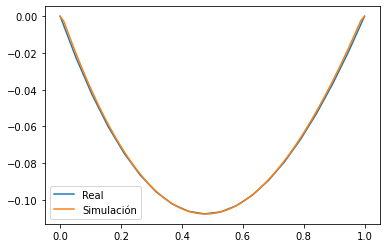

In [68]:
y = lambda x: 1 - np.cos(x) + (np.cos(1) - 1)*x
Γ_0 = Γ_1 = 0
x = np.linspace(0,1,nx+2)
x1 = np.linspace(0,1,20)
plt.plot(x1, y(x1))
plt.plot(x, [Γ_0] + list(sistema.get_solution()) + [Γ_1])
plt.legend(["Real", "Simulación"])
plt.show()

---

[Volver al índice](#Índice)

### Una dimensión con advección
Problema 5.1 del Malalasekera

In [69]:
#-------------Definición de datos iniciales ----------------
lx = 1.0 # meters
TA = 1.0 # °C 
TB = 0 # °C 
Γ  = 0.1 # Kg/m.s
nvx  =  5 # Número de volumenes
u = 0.1 # m/s
ρ = 1. # Kg/m²

In [70]:
# ------------Mesh creation -----------------
malla = Mesh(1, volumes=nvx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
#malla.draw()

In [71]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)

In [72]:
vel = np.array(u*np.ones(nvx)).reshape(nvx,1,1)
coef.set_diffusion(Γ)
coef.set_advection(ρ, (vel,))

In [73]:
sistema = EqSystem(coef)


In [74]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [0.93186823 0.78538492 0.60960494 0.39866898 0.14554582]


---

[Volver al índice](#Índice)

Ejemplo 6.2 del libro _Numerical Methods for partial differential equations_

In [75]:
#------------- Initial data definition ----------------
lx = 1 # meters
TA = 1 # °C 
TB = 0 # °C 
Γ  = 10 # W/m.K 
ρ = 1
u = 1
nx  = 50# number of volumes
#-------------------------------------------------------------

In [76]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [77]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(Γ)
vel = np.array(u*np.ones(nx)).reshape(nx,1,1)
coef.set_advection(ρ, (vel,)) #En general 

In [78]:
sistema = EqSystem(coef)

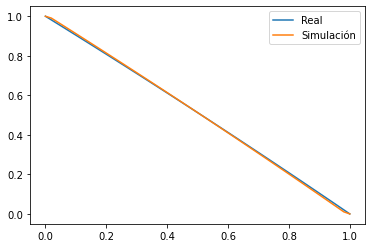

In [79]:
Γ_0 = 1
Γ_1 = 0
y = lambda x: (np.exp(0.1) - np.exp(0.1*x)) / (np.exp(0.1) - 1)
x1 = np.linspace(0,1,20)
x = np.linspace(0,1,nx+2)
plt.plot(x1, y(x1))
plt.plot(x, [Γ_0] + list(sistema.get_solution()) + [Γ_1])
plt.legend(["Real", "Simulación"])
plt.show()

---

[Volver al índice](#Índice)

## Dos dimensiones
El problema 7.2 del malaskera es el chido para ver esto, junto con el ejemplo de juguete

In [80]:
#-------------Definición de datos iniciales ----------------
lx = 0.3 # meters
ly = 0.4
lz = 0.01
Fw = 500_000 # W/m²
Tn = 100 # ºC
α = 6
nvx  = 3*α
nvy = 4*α
k = 1_000
#-------------------------------------------------------------

In [81]:
#--------malla T -------------------------
malla = Mesh(2, volumes = (nvx, nvy), lengths = (lx, ly, lz))
malla.tag_wall_neumann("W", Fw) # Esta es la condición original del problema
#malla.tag_wall_dirichlet("W", Fw)
malla.tag_wall_dirichlet("N", Tn)
malla.tag_wall_insulated(["E", "S"])
malla.draw()

In [82]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)

In [83]:
sistema = EqSystem(coef)

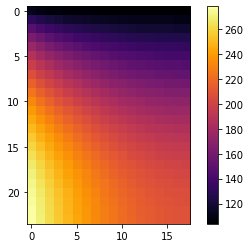

In [84]:
plt.imshow(sistema.get_solution().reshape((nvx,nvy)).T, cmap = "inferno")
plt.colorbar()

---

[Volver al índice](#Índice)

## Ecuación de Poisson

In [85]:
#-------------Definición de datos iniciales ----------------
lx = 0.3 # meters
ly = 0.4
lz = 0.01
Fw = 500_000 # W/m²
Tn = 100 # ºC
α = 20
nvx  = 3*α
nvy = 4*α
k = 1_000
#-------------------------------------------------------------

In [86]:
#--------malla T -------------------------
malla = Mesh(2, volumes = (nvx, nvy), lengths = (lx, ly, lz))
malla.tag_wall_dirichlet("N", Tn)
malla.tag_wall_dirichlet(["E", "S", "W"], [0,0,0])
malla.draw()

In [87]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)

In [88]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
b = sistema.get_b_vector()

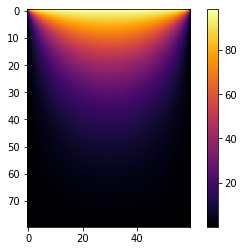

In [89]:
plt.imshow(sistema.get_solution().reshape((nvx,nvy)).T, cmap = "inferno")
plt.colorbar()

---

[Volver al índice](#Índice)

## Tres dimensiones

In [109]:
#-------------Definición de datos iniciales ----------------
lx = 0.5 # meters
ly = 0.5
lz = 0.5
Tn = 100 # ºC
α = 2
nvx  = 5*α
nvy = 5*α
nvz = 5*α
k = 1_000
#-------------------------------------------------------------

In [118]:
#--------malla T -------------------------
malla = Mesh(3, volumes = (nvx, nvy, nvz), lengths = (lx, ly, lz))
#malla.tag_wall_neumann("W", Fw) # Esta es la condición original del problema
#malla.tag_wall_dirichlet("W", Fw)
malla.tag_wall_dirichlet("S", Tn)
malla.tag_wall_dirichlet(["W", "E", "T", "N", "B"], [0,0,0,0,0])
malla.draw()

In [119]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)

In [120]:
sistema = EqSystem(coef)

In [121]:
x,y,z = [np.array(coord) for coord in malla.coords]
xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
  
fig = go.Figure(data = go.Scatter3d(x = xv.ravel(), y = yv.ravel(), z = zv.ravel(), mode = 'markers', 
                                    marker = dict(color = sistema.get_solution(), 
                                                symbol = "square", size = 5), text = sistema.get_solution()))
fig.show()

---

[Volver al índice](#Índice)

# Lid-driven Cavity

In [95]:
# Variables del problema
u_0 = 100 #m/s
h = 1 # m
l = 1 # m
ρ = 10 # kg/m³
μ = 0.1 # 
Re = ρ*u_0*l/μ #ρUH/μ

In [96]:
# Definiendo la malla
nvx = 8
nvy = 8

#--------malla T -------------------------
malla_p = Mesh(2, volumes = (nvx, nvy), lengths = (l, h, 0.1))

In [97]:
malla_u = StagMesh(malla_p,0)
malla_v = StagMesh(malla_p,1)
malla_u.tag_wall_dirichlet("N S E W".split(), [u_0,0,0,0])
malla_v.tag_wall_dirichlet("N S E W".split(), [0,0,0,0])

In [98]:
#malla_u.draw()

In [99]:
simp = Simple([malla_p, malla_u, malla_v], μ, ρ)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
p, (vx,vy) = simp.get_solutions()

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,5))

cs_0 = ax[0].contourf(vx.reshape(nvx - 1,nvy), cmap = "inferno")
ax[0].contour(cs_0)
ax[0].set_title("Velocidades dirección x, una iteración")
fig.colorbar(cs_0, ax=ax[0])

cs_1 = ax[1].contourf(vy.reshape(nvx,nvy-1), cmap = "inferno")
ax[1].contour(cs_1)
ax[1].set_title("Velocidades dirección y, una iteración")
fig.colorbar(cs_1, ax=ax[1])

cs_2 = ax[2].contourf(p.reshape(nvx,nvy), cmap = "inferno")
ax[2].contour(cs_2)
ax[2].set_title("Presiones, una iteración");
fig.colorbar(cs_2, ax=ax[2])

In [ ]:
vels, pressure = simp.loop_system(max_iter = 2)

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,5))

u_vel = vels[0]
cs_0 = ax[0].contourf(u_vel.reshape(nvx -1,nvy).T, cmap = "inferno")
ax[0].contour(cs_0)
ax[0].set_title("Velocidades dirección x")
fig.colorbar(cs_0, ax=ax[0])

v_vel = vels[1]
cs_1 = ax[1].contourf(v_vel.reshape(nvx,nvy-1).T, cmap = "inferno")
ax[1].contour(cs_1)
ax[1].set_title("Velocidades dirección y")
fig.colorbar(cs_1, ax=ax[1])

cs_2 = ax[2].contourf(pressure.reshape(nvx,nvy).T, cmap = "inferno")
ax[2].contour(cs_2)
ax[2].set_title("Presiones")
fig.colorbar(cs_2, ax=ax[2]);

---

[Volver al índice](#Índice)